In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import sys
import time

import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as mpcm

/home/zack/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zack/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zack/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zack/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

In [2]:
sys.path.append("..")

# Grab path to current working directory 
CWD_PATH = os.getcwd() 
# Path to frozen detection graph .pb file, which contains the model that is used 
# for object detection. 
PATH_TO_CKPT = os.path.join('/eDisk/Zack_SSD_mv2/001_ssdmv2','frozen_inference_graph.pb') 
# Path to label map file 
# PATH_TO_LABELS = os.path.join(CWD_PATH,'my_training_mnv2_ssd','my_data_label_map.pbtxt') 

# # for object detection. 
# PATH_TO_CKPT = os.path.join(CWD_PATH,'my_training_mnv2_ssd/ssd_mobilenet_v2_coco_2018_03_29/','frozen_inference_graph.pb') 
# # Path to label map file 
# PATH_TO_LABELS = os.path.join(CWD_PATH,'my_training_mnv2_ssd','mscoco_label_map.pbtxt') 


# Number of classes the object detector can identify 
NUM_CLASSES = 2

In [3]:

detection_graph = tf.Graph() 

with detection_graph.as_default(): 
    
    od_graph_def = tf.GraphDef() 
    
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid: 
        
        serialized_graph = fid.read() 
        od_graph_def.ParseFromString(serialized_graph) 
        tf.import_graph_def(od_graph_def, name='') 
        
    sess = tf.Session(graph=detection_graph) 


In [4]:
# Input tensor is the image
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Output tensors are the detection boxes, scores, and classes 
# Each box represents a part of the image where a particular object was detected 
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label. 
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0') 
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = detection_graph.get_tensor_by_name('num_detections:0')

In [5]:
image_tensor

<tf.Tensor 'image_tensor:0' shape=(?, ?, ?, 3) dtype=uint8>

In [6]:
detection_boxes

<tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>

In [7]:
detection_scores

<tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>

In [8]:
detection_classes

<tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>

In [9]:
MY_DATA_LABELS = {
    0:'non',
    1:'car',
    2:'bus'
} 

# MY_DATA_LABELS = {
#     0:'non',1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6: "bus",7: "train",8: "truck",9: "boat",10: "traffic light",
#     11: "fire hydrant",13: "stop sign",14: "parking meter",15: "bench",16: "bird",17: "cat",18: "dog",19: "horse",
#     20: "sheep",21:"cow",22: "elephant", 23: "bear",24: "zebra",25: "giraffe",27: "backpack",28: "umbrella",
#     31: "handbag",32: "tie",33: "suitcase",34: "frisbee",35: "skis",36: "snowboard",37:"sports ball",38: "kite",39: "baseball bat",
#     40: "baseball glove",41: "skateboard",42: "surfboard",43: "tennis racket",44: "bottle",46: "wine glass",47: "cup",48: "fork",
#     49: "knife",50: "spoon",51: "bowl",52: "banana",53: "apple",54:"sandwich",55: "orange",56: "broccoli",57: "carrot",58: "hot dog",59: "pizza",
#     60: "donut",61: "cake",62: "chair",63: "couch",64: "potted plant",65: "bed",
#     67: "dining table",70: "toilet",72: "tv",73:"laptop",74: "mouse",75: "remote",76: "keyboard",77: "cell phone",78: "microwave",79: "oven",
#     80: "toaster",81: "sink",82: "refrigerator",84: "book",85: "clock",86: "vase",87: "scissors",88: "teddy bear",89: "hair drier",90: "toothbrush",
# } 

def colors_subselect(colors, num_classes=21):
    dt = len(colors) // num_classes
    sub_colors = []
    for i in range(num_classes):
        color = colors[i*dt]
        if isinstance(color[0], float):
            sub_colors.append([int(c * 255) for c in color])
        else:
            sub_colors.append([c for c in color])
    return sub_colors

colors_plasma = colors_subselect(mpcm.plasma.colors, num_classes=21)
colors_tableau = [(255, 255, 255), (31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
                  (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
                  (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
                  (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
                  (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

def plt_bboxes(img,rshape, classes, scores, bboxes, figsize=(50,50), linewidth=5):
    """Visualize bounding boxes. Largely inspired by SSD-MXNET!
    """
    fig = plt.figure(figsize=figsize)
    img_ = img[:,:,[2,1,0]]
    plt.imshow(img_)
    height = rshape[0]
    width = rshape[1]
    colors = dict()
    for i in range(len(classes)):
        cls_id = int(classes[i])
        if cls_id >= 0:
            score = scores[i]
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            ymin = int(bboxes[i][0] * height)
            xmin = int(bboxes[i][1] * width)
            ymax = int(bboxes[i][2] * height)
            xmax = int(bboxes[i][3] * width)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=linewidth)
            plt.gca().add_patch(rect)
#             class_name = str(MY_DATA_LABELS[cls_id])
            class_name = str(MY_DATA_LABELS[cls_id])
  
            plt.gca().text(xmin, ymin - 2,
                           '{:s} | {:.3f}'.format(class_name, score),
                           bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                           fontsize=30, color='white')
    plt.show()

start time: 1575256729.6439805
one img total time: 1.737365484237671


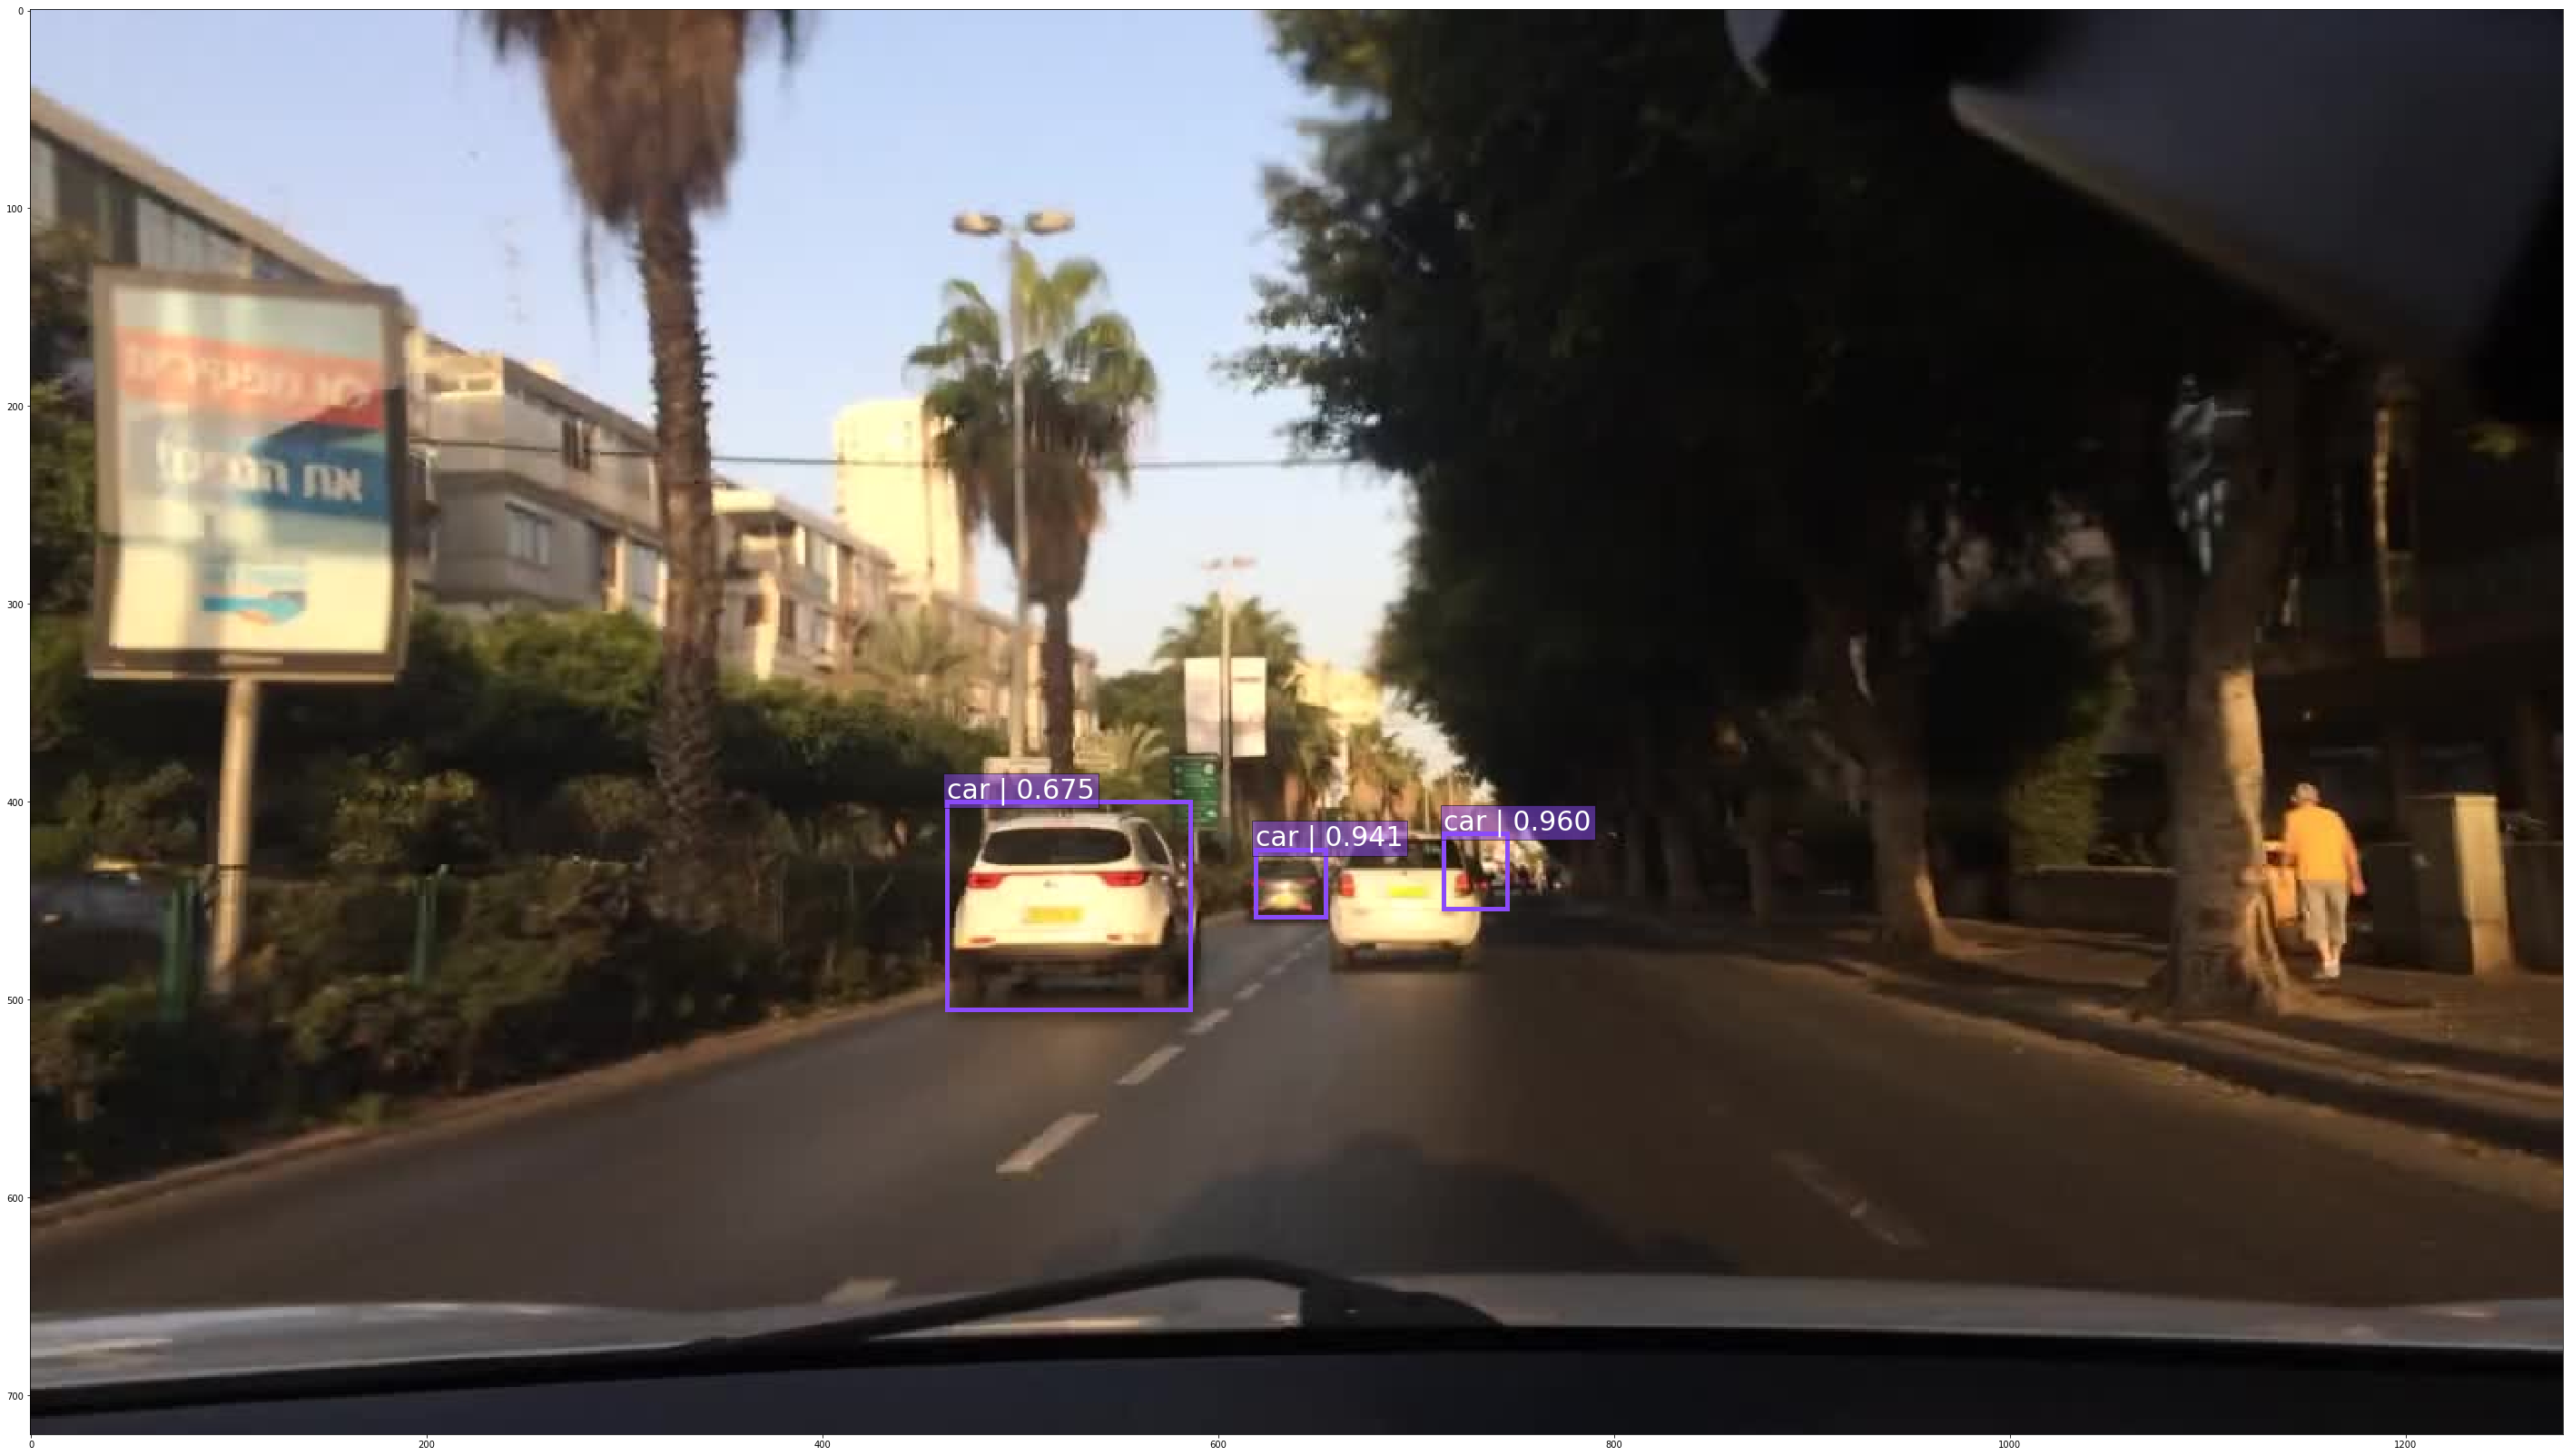

start time: 1575256733.1245854
one img total time: 0.008815288543701172


KeyboardInterrupt: 

In [10]:
# import visualization
%matplotlib inline

all_total_time = []
select_threshold = 0.5

for parent, dirnames, filenames in os.walk('/home/zack/studio/Github/ssd_kerasV2/example/img'):
    for filename in filenames:
        full_filename = os.path.join(parent,filename)
        img = cv2.imread(full_filename)
        image_expanded = np.expand_dims(img, axis=0)


        start = time.time()
        print('start time:',start)
        boxes,scores,classes,num = sess.run([detection_boxes,detection_scores,detection_classes,num_detections],
            feed_dict={image_tensor: image_expanded})
        
#         print(boxes)
#         print(scores)
#         print(classes)
#         print(num)

        elapsed = (time.time() - start)
        all_total_time.append(elapsed)

        print('one img total time:',elapsed)

        rshape = img.shape
        rlabels_ = np.squeeze(classes).astype(np.int32)
        rscores_ = np.squeeze(scores)
        rbboxes_ = np.squeeze(boxes)
        pass_num = [i for i,x in enumerate(rscores_) if x>=select_threshold]

        rlabels = []
        rscores = []
        rbboxes = []
        for j in pass_num:
            rlabels.append(rlabels_[j])
            rscores.append(rscores_[j])
            rbboxes.append(rbboxes_[j])

        plt_bboxes(img,rshape,rlabels,rscores,rbboxes)

In [ ]:
# # import visualization
# %matplotlib inline

# all_total_time = []
# select_threshold = 0.5

# for parent, dirnames, filenames in os.walk('./img__1'):
#     for filename in filenames:
#         full_filename = os.path.join(parent,filename)
#         img = cv2.imread(full_filename)
#         image_expanded = np.expand_dims(img, axis=0)


#         start = time.time()
#         print('start time:',start)
#         boxes,scores,classes,num = sess.run([detection_boxes,detection_scores,detection_classes,num_detections],
#             feed_dict={image_tensor: image_expanded})

#         elapsed = (time.time() - start)
#         all_total_time.append(elapsed)

#         print('one img total time:',elapsed)

#         rshape = img.shape
#         rlabels_ = np.squeeze(classes).astype(np.int32)
#         rscores_ = np.squeeze(scores)
#         rbboxes_ = np.squeeze(boxes)
#         pass_num = [i for i,x in enumerate(rscores_) if x>=select_threshold]

#         rlabels = []
#         rscores = []
#         rbboxes = []
#         for j in pass_num:
#             rlabels.append(rlabels_[j])
#             rscores.append(rscores_[j])
#             rbboxes.append(rbboxes_[j])

#         plt_bboxes(img,rshape,rlabels,rscores,rbboxes)

In [ ]:

colors_map = {
    1:(31, 119, 180),2:(174, 199, 232),
    3:(197, 176, 213),4:(196, 156, 148),
    5:(148, 103, 189)
}

MY_DATA_LABELS = {
    0:'non',
    1:'bus',
    2:'person',
    3:'truck',
    4:'car',
    5:'bike'
} 


In [ ]:
colors_map[4]

In [ ]:
# colors_map[cls_id]

In [ ]:
# cv2.rectangle(img,(xmin,ymax),(xmax,ymin),colors_map[cls_id],2)

In [ ]:
# '{:s} | {:.3f}'.format(class_name, rscores[i])

# class_name + str(rscore

# 10/2

In [ ]:
# import numpy as np
import cv2

select_threshold = 0.5
model_ckpt = '424725'

video_name = "test_20190719_003.avi"

test_video_path = './test_videos/' + video_name 

cap = cv2.VideoCapture(test_video_path)
# cap = cv2.VideoCapture('36864912-1-64.flv')
out_video_name = 'out_' + "test_20190719_009_"+ model_ckpt + '.avi'
#创建视频写入对象 
out = cv2.VideoWriter(out_video_name, 
                    cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), 
                    cap.get(cv2.CAP_PROP_FPS), 
                    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), 
                    int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))) 



while(cap.isOpened()):
    
    ret, frame = cap.read()
#     print(ret)
    if ret == True :
#         frame = cv2.cvtColor(frame，COLOR)
        frame_expand = np.expand_dims(frame, axis=0)
        
        boxes,scores,classes,num = sess.run([detection_boxes,detection_scores,detection_classes,num_detections],
                                            feed_dict={image_tensor: frame_expand})

        rshape = frame.shape
        rlabels_ = np.squeeze(classes).astype(np.int32)
        rscores_ = np.squeeze(scores)
        rbboxes_ = np.squeeze(boxes)
        
        pass_num = [i for i,x in enumerate(rscores_) if x>=select_threshold]

        rlabels = []
        rscores = []
        rbboxes = []
        for j in pass_num:
            rlabels.append(rlabels_[j])
            rscores.append(rscores_[j])
            rbboxes.append(rbboxes_[j])
            
        height = rshape[0]
        width = rshape[1]
        colors = dict()
        for i in range(len(rlabels)):
            cls_id = int(rlabels[i])
            if cls_id >= 0:
                score = rscores_[i]
                ymin = int(rbboxes[i][0] * height)
                xmin = int(rbboxes[i][1] * width)
                ymax = int(rbboxes[i][2] * height)
                xmax = int(rbboxes[i][3] * width)
                
                class_name = str(MY_DATA_LABELS[cls_id])
                text = '{:s} | {:.3f}'.format(class_name, rscores[i])
#                 图片，添加的文字，左上角坐标，字体，字体大小，颜色，字体粗细
                cv2.rectangle(frame,(xmin,ymax),(xmax,ymin),colors_map[cls_id],2)
                cv2.putText(frame, str(text), (xmin,ymin-5), cv2.FONT_HERSHEY_TRIPLEX, 0.5,colors_map[cls_id], 1)


        cv2.imshow('frame', frame)
        
#         out.write(frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
random.random()

In [ ]:
import cv2
import time

# cap = cv2.VideoCapture('test2.mp4')
cap = cv2.VideoCapture('44455800-1-64.flv')

count_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT)
print(count_frame)
i = 0
start = time.time()
while(cap.isOpened()):
#     print(count_frame)
    i = i+1
    ret, frame = cap.read()
    if ret == True:
    
        cv2.imshow('frame', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
        if cv2.waitKey(1) & 0xFF == ord(' '):
            cv2.waitKey(0)
    else:
        break
elapsed = (time.time() - start)
print(elapsed)
fps = cap.get(cv2.CAP_PROP_FPS)
print('fps',fps)
print('i',i)


cap.release()
cv2.destroyAllWindows()

In [ ]:
count_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT)

In [ ]:
count_frame